In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score
from tqdm import tqdm

sns.set_theme(style="whitegrid")

In [2]:
df = pd.read_csv('https://github.com/ArinB/MSBA-CA-03-Decision-Trees/blob/master/census_data.csv?raw=true')
df.head(10)

,hours_per_week_bin,occupation_bin,msr_bin,capital_gl_bin,race_sex_bin,education_num_bin,education_bin,workclass_bin,age_bin,flag,y
0,b. 31-40,b. Mid - Low,b. Mid,c. > 0,c. High,c. 13,c. Bachelors,b. income,d. 36-40 & 56-60,train,0
1,a. 0-30,e. High,c. High,a. = 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,0
2,b. 31-40,a. Low,b. Mid,a. = 0,c. High,b. 9-12,b. Mid,b. income,d. 36-40 & 56-60,train,0
3,b. 31-40,a. Low,c. High,a. = 0,b. Mid,a. 0-8,a. Low,b. income,e. 40-55,train,0
4,b. 31-40,e. High,c. High,a. = 0,a. Low,c. 13,c. Bachelors,b. income,b. 26-30 & 71-100,train,0
5,b. 31-40,e. High,c. High,a. = 0,b. Mid,d. 14,d. Masters,b. income,d. 36-40 & 56-60,train,0
6,a. 0-30,a. Low,b. Mid,a. = 0,a. Low,a. 0-8,a. Low,b. income,e. 40-55,train,0
7,d. 41-50 & 61-70,e. High,c. High,a. = 0,c. High,b. 9-12,b. Mid,b. income,e. 40-55,train,1
8,d. 41-50 & 61-70,e. High,b. Mid,c. > 0,b. Mid,d. 14,d. Masters,b. income,c. 31-35 & 61-70,train,1
9,b. 31-40,e. High,c. High,c. > 0,c. High,c. 13,c. Bachelors,b. income,e. 40-55,train,1


## 2. Data cleaning and transformation


Based on the data quality report (from CA03):
- There were no missing values, so no imputation is necessary.
- All data points are correctly formatted, and there are no obvious incorrect entries.

Therefore, no data cleaning is needed.

Decision Trees in libraries like scikit-learn require numerical input, so categorical variables must be encoded. For this dataset, since all features except the target are categorical, we will apply one-hot encoding to transform them. Specifically, the next code block will perform the following transformation steps:
- Split the data into a training set and a test set and drop the `flag` feature.
- Apply one-hot encoding to categorical variables.
- Separate the features from the target variable.

In [3]:
# separate train and test set using the 'flag' column
train_data = df[df['flag'] == 'train']
test_data = df[df['flag'] == 'test']

# drop the 'flag' column
train_data = train_data.drop('flag', axis=1)
test_data = test_data.drop('flag', axis=1)

# One-hot encode the categorical variables
X_train = pd.get_dummies(train_data.drop('y', axis=1))
y_train = train_data['y']
X_test = pd.get_dummies(test_data.drop('y', axis=1))
y_test = test_data['y']

# Check the shapes to ensure that the encoding worked correctly
print (X_train.shape, X_test.shape)
print (y_train.shape, y_test.shape)
X_train.head(10)

(32561, 36) (16281, 36)
(32561,) (16281,)


,hours_per_week_bin_a. 0-30,hours_per_week_bin_b. 31-40,hours_per_week_bin_c. 71-100,hours_per_week_bin_d. 41-50 & 61-70,hours_per_week_bin_e. 51-60,occupation_bin_a. Low,occupation_bin_b. Mid - Low,occupation_bin_c. Mid - Mid,occupation_bin_d. Mid - High,occupation_bin_e. High,...,education_bin_c. Bachelors,education_bin_d. Masters,education_bin_e. High,workclass_bin_a. no income,workclass_bin_b. income,age_bin_a. 0-25,age_bin_b. 26-30 & 71-100,age_bin_c. 31-35 & 61-70,age_bin_d. 36-40 & 56-60,age_bin_e. 40-55
0,False,True,False,False,False,False,True,False,False,False,...,True,False,False,False,True,False,False,False,True,False
1,True,False,False,False,False,False,False,False,False,True,...,True,False,False,False,True,False,False,False,False,True
2,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,True,False
3,False,True,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
4,False,True,False,False,False,False,False,False,False,True,...,True,False,False,False,True,False,True,False,False,False
5,False,True,False,False,False,False,False,False,False,True,...,False,True,False,False,True,False,False,False,True,False
6,True,False,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,True
7,False,False,False,True,False,False,False,False,False,True,...,False,False,False,False,True,False,False,False,False,True
8,False,False,False,True,False,False,False,False,False,True,...,False,True,False,False,True,False,False,True,False,False
9,False,True,False,False,False,False,False,False,False,True,...,True,False,False,False,True,False,False,False,False,True


## Helper functions

In [4]:
def plot_hyperparameter_vs_metric(hp, metric, title, xlabel, ylabel):
    plt.figure(figsize=(10, 6))
    plt.plot(hp, metric, marker='o')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(True)
    plt.show()

## 3. Hyperparameter tuning for Random Forest

In [5]:
n_estimators_values = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

rf_accuracies = []
rf_auc_scores = []

for n in tqdm(n_estimators_values):
    model = RandomForestClassifier(n_estimators=n, random_state=42)    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    rf_accuracies.append(accuracy_score(y_test, y_pred))
    rf_auc_scores.append(roc_auc_score(y_test, y_pred))

100%|██████████| 10/10 [00:39<00:00,  3.98s/it]


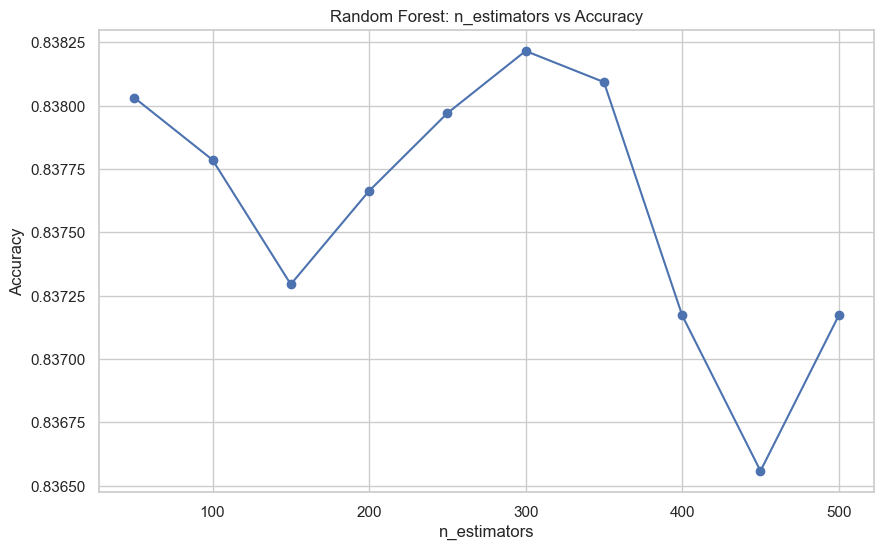

In [6]:
plot_hyperparameter_vs_metric(n_estimators_values, rf_accuracies, 'Random Forest: n_estimators vs Accuracy', 'n_estimators', 'Accuracy')

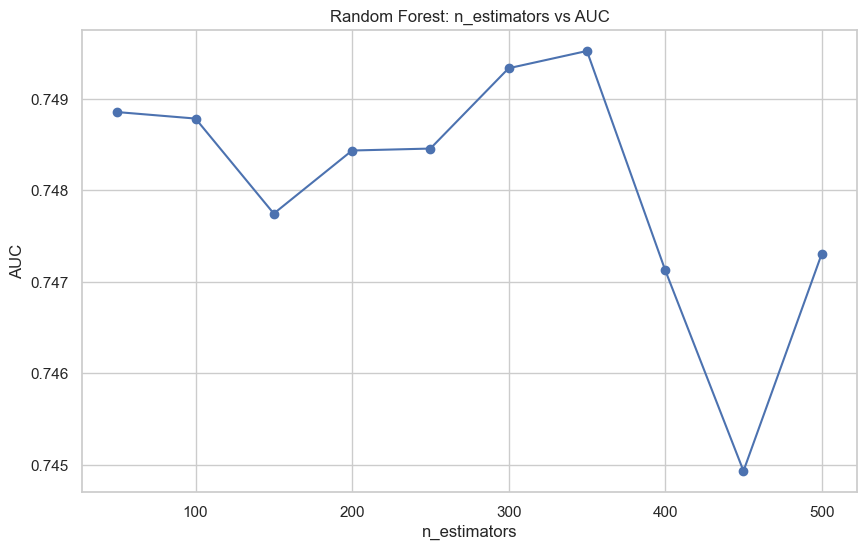

In [7]:
plot_hyperparameter_vs_metric(n_estimators_values, rf_auc_scores, 'Random Forest: n_estimators vs AUC', 'n_estimators', 'AUC')

### Questions

1 - Write your observations about the Classifier’s behavior with respect to the number
of estimators

The performance of the classifier with respect to both Accuracy and AUC tends to improve as we increase the number of estimators to a certain value, followed by a decreasing trend beyond that value. However, the model is quite robust to the number of estimators as the performance does not vary significantly.

2 - Is there an optimal value of the estimator within the given range?

Yes, based on the two graphs, the optimal number of estimators is around 300 to 350.

## 4. Hyperparameter tunining for AdaBoost

In [8]:
n_estimators_values = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

ada_accuracies = []
ada_auc_scores = []

for n in tqdm(n_estimators_values):
    model = AdaBoostClassifier(n_estimators=n, random_state=42)    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    ada_accuracies.append(accuracy_score(y_test, y_pred))
    ada_auc_scores.append(roc_auc_score(y_test, y_pred))

100%|██████████| 10/10 [00:35<00:00,  3.55s/it]


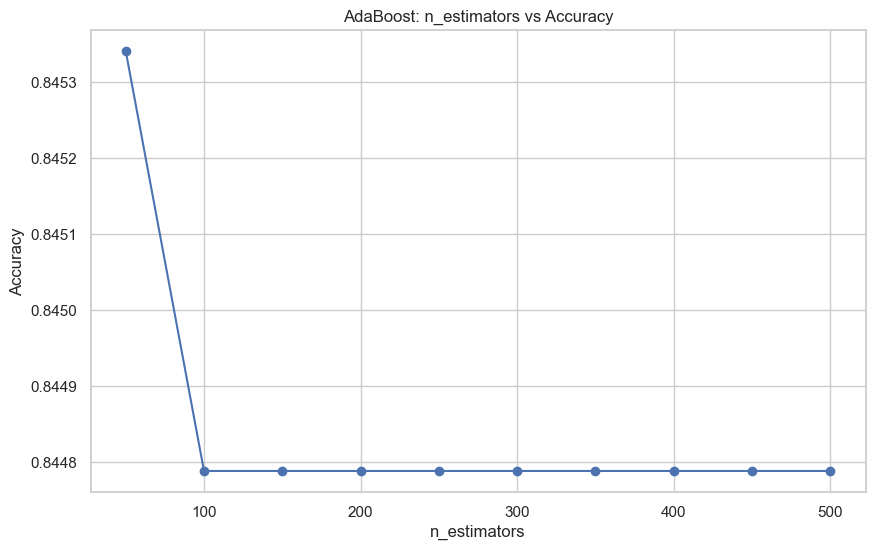

In [9]:
plot_hyperparameter_vs_metric(n_estimators_values, ada_accuracies, 'AdaBoost: n_estimators vs Accuracy', 'n_estimators', 'Accuracy')

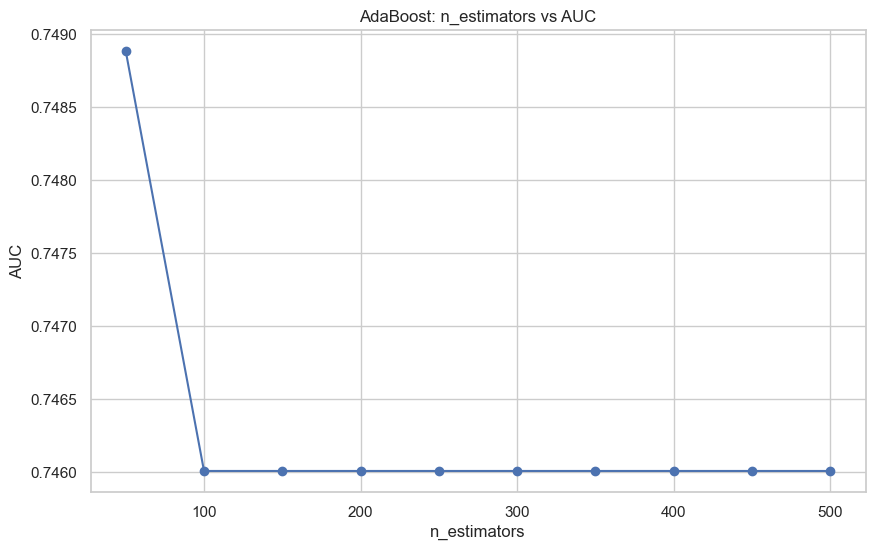

In [10]:
plot_hyperparameter_vs_metric(n_estimators_values, ada_auc_scores, 'AdaBoost: n_estimators vs AUC', 'n_estimators', 'AUC')

### Questions

1 - Write your observations about the Classifier’s behavior with respect to the number
of estimators

The performance of the classifier with respect to both Accuracy and AUC drops as we increase the number of estimators. This may be a sign of overfitting.

2 - Is there an optimal value of the estimator within the given range?

Yes, based on the two graphs, the optimal number of estimators is 50.

## 5. Hyperparameter tunining for Gradient Boost

In [11]:
n_estimators_values = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

gb_accuracies = []
gb_auc_scores = []

for n in tqdm(n_estimators_values):
    model = GradientBoostingClassifier(n_estimators=n, random_state=42)    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    gb_accuracies.append(accuracy_score(y_test, y_pred))
    gb_auc_scores.append(roc_auc_score(y_test, y_pred))

100%|██████████| 10/10 [00:54<00:00,  5.45s/it]


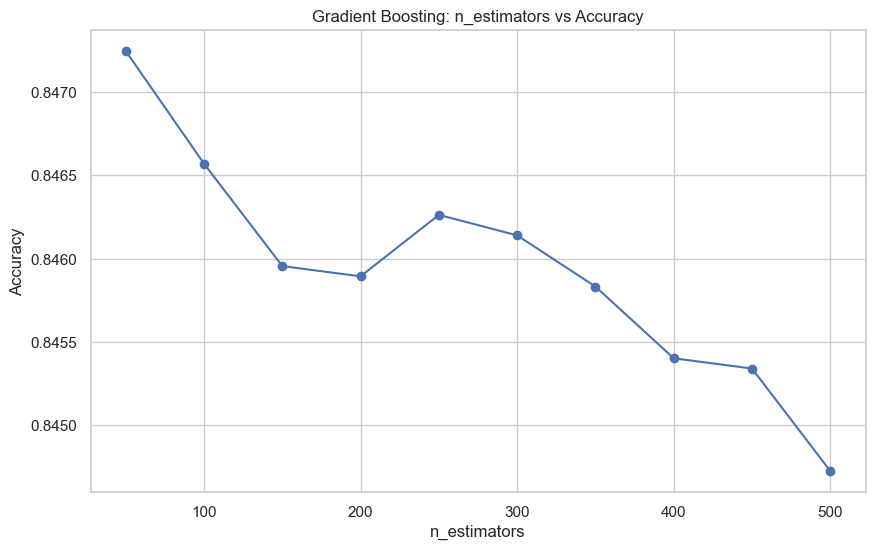

In [12]:
plot_hyperparameter_vs_metric(n_estimators_values, gb_accuracies, 'Gradient Boosting: n_estimators vs Accuracy', 'n_estimators', 'Accuracy')

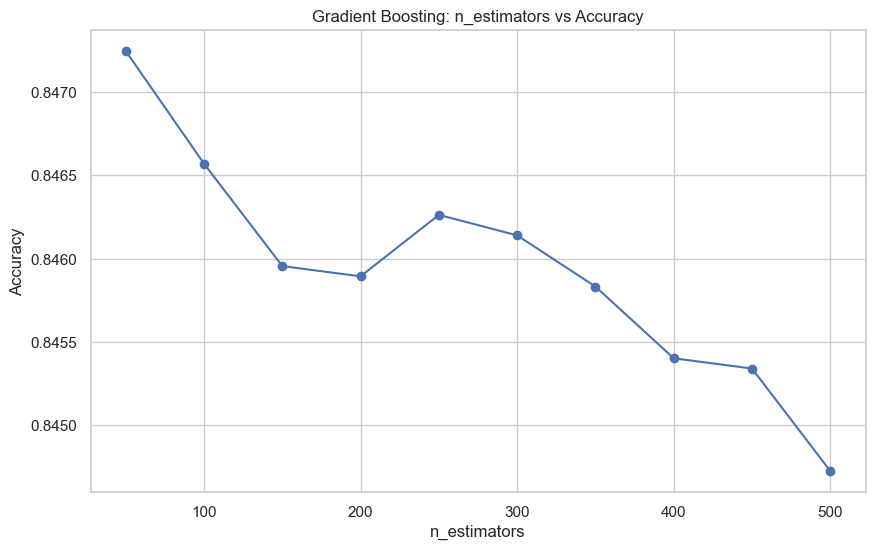

In [13]:
plot_hyperparameter_vs_metric(n_estimators_values, gb_accuracies, 'Gradient Boosting: n_estimators vs Accuracy', 'n_estimators', 'Accuracy')

### Questions

1 - Write your observations about the Classifier’s behavior with respect to the number
of estimators

The performance of the classifier with respect to both Accuracy and AUC tends to decrease as we increase the number of estimators. This may be a sign of overfitting.

2 - Is there an optimal value of the estimator within the given range?

Yes, based on the two graphs, the optimal number of estimators is 50.

## 6. Hyperparameter tunining for XGB

In [14]:
n_estimators_values = [50, 100, 150, 200, 250, 300, 350, 400, 450, 500]

xgb_accuracies = []
xgb_auc_scores = []

for n in tqdm(n_estimators_values):
    model = XGBClassifier(n_estimators=n, random_state=42)    
    model.fit(X_train.to_numpy(), y_train.to_numpy())
    y_pred = model.predict(X_test.to_numpy())
    xgb_accuracies.append(accuracy_score(y_test.to_numpy(), y_pred))
    xgb_auc_scores.append(roc_auc_score(y_test.to_numpy(), y_pred))

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:10<00:00,  1.07s/it]


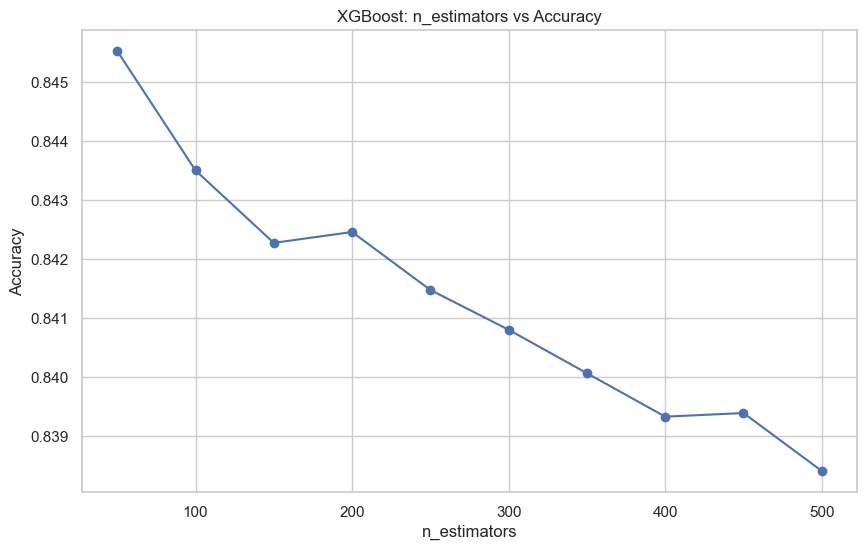

In [15]:
plot_hyperparameter_vs_metric(n_estimators_values, xgb_accuracies, 'XGBoost: n_estimators vs Accuracy', 'n_estimators', 'Accuracy')

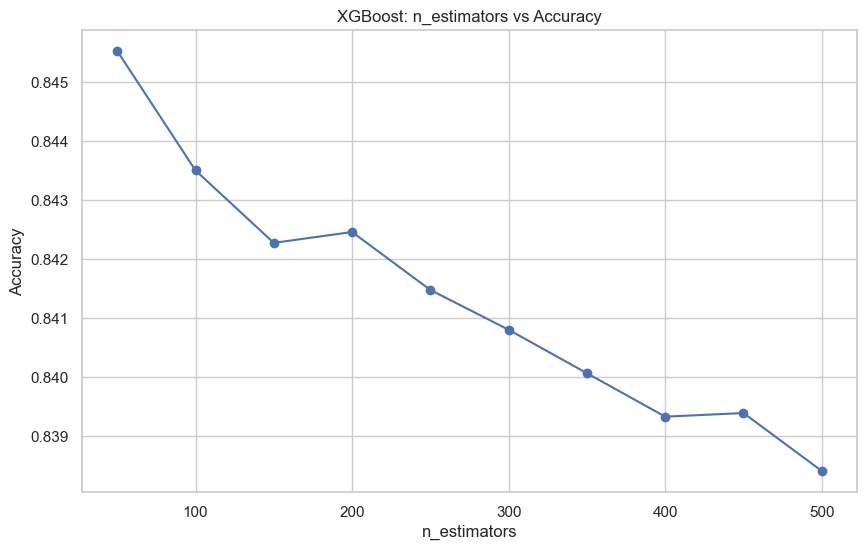

In [16]:
plot_hyperparameter_vs_metric(n_estimators_values, xgb_accuracies, 'XGBoost: n_estimators vs Accuracy', 'n_estimators', 'Accuracy')

### Questions

1 - Write your observations about the Classifier’s behavior with respect to the number
of estimators

The performance of the classifier with respect to both Accuracy and AUC tends to decrease as we increase the number of estimators. This may be a sign of overfitting.

2 - Is there an optimal value of the estimator within the given range?

Yes, based on the two graphs, the optimal number of estimators is 50.

## 7. Compare Performance

In [17]:
performance_data = {
    'Random Forest': {'Accuracy': max(*rf_accuracies), 'AUC': max(*rf_auc_scores)},
    'AdaBoost': {'Accuracy': max(*ada_accuracies), 'AUC': max(*ada_auc_scores)},
    'Gradient Boost': {'Accuracy': max(*gb_accuracies), 'AUC': max(*gb_auc_scores)},
    'XGB': {'Accuracy': max(*xgb_accuracies), 'AUC': max(*xgb_auc_scores)}
}
performance_df = pd.DataFrame(performance_data)
performance_df

,Random Forest,AdaBoost,Gradient Boost,XGB
Accuracy,0.838216,0.845341,0.847245,0.845525
AUC,0.749527,0.748884,0.758584,0.757984
